# 2021 추천 여행지

In [12]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [13]:
df = pd.read_csv('../data_travel/2021 추천 여행지.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20230622,"© geojango_maps, 출처 Unsplash 안녕하세요, 열림협동조합(열림여...",2023 투어케어 인력 양성 교육에 참여하게 되어 현장 답사와 실습을 진행하게되었는...,2021년 열린관광지 행주산성 / 고양시 여행지 추천
1,20240207,"2021년 1월, 새해에는 해외 여행으로 새로운 경험을 쌓고 싶은 사람들에게 가볼만...",위의 <b>여행지<\/b>는 <b>2021년<\/b> 1월에 가볼만한 해외 <b>여...,"2021년 1월, 가볼만한 해외 여행지 TOP 10"
2,20231028,"2021년 연말을 위한 추천 여행지 2021년이 점점 가까워지고 있는 지금, 많은 ...",<b>2021년<\/b> 연말을 위한 <b>추천 여행지<\/b> <b>2021년<\...,2021년 연말을 위한 추천 여행지
3,20240306,"'2021년 8월, 꼭 가봐야 할 여행지 TOP 10' 여름의 뜨거운 햇살과 시원한...","'<b>2021년<\/b> 8월, 꼭 가봐야 할 <b>여행지<\/b> TOP 10'...","2021년 8월, 꼭 가봐야 할 여행지 TOP 10"
4,20231104,2021년 최고의 여행지! 세계 일주를 꿈꾸는 당신을 위한 추천 명소 TOP 10 ...,<b>2021년<\/b> 최고의 <b>여행지<\/b>! 세계 일주를 꿈꾸는 당신을 ...,2021년 최고의 여행지! 세계 일주를 꿈꾸는 당신을 위한 추천 명소 TOP 10


## 1. 전처리

In [14]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [15]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['여행지', '2021년', '여행', '추천', '사진', '코스', '사람', '마을','방문', '다양', '정도', '모습',
                        '생각', '거리', '이용', '위치', '유명', '가능', '소개', '선정', '시작', '오늘', '관광', '지역', '장소',
                        '세계', '올해', '기간', '제목', '때문', '주차장', '예약', '투어', '공간', '구경', '문화', '날씨', '인기',
                        '나라', '주변', '운영', '마음', '무료', '자리', '최고', '준비', '대표', '매력', '주차', '감상', '아래',
                        '분위기', '정보', '입구', '이동', '사랑', '할인', '특별', '일정', '시설', '건물', '진행', '계획', '보이',
                        '가지', '시기', '대하', '입장료', '이름', '아침', '도착', '경우', '규모', '입장', '포스팅', '마지막', '가격',
                        '촬영', '접기펴기', '이야기', '사용', '포토', '작품', '이유', '기억', '출처', '상품', '시대', '하루', '조성',
                        '인생', '필요', '친구', '워크', '사이', '경험', '출발', '선택', '영상', '처음', '최대', '이후', '제공', '기분',
                        '중간', '지금', '계단', '요즘', '개인', '프로그램', '관광객', '곳곳', '소리', '요금', '오후', '주소', '안내',
                        '필수', '행사', '근처', '안전', '방법', '안녕하세요', '부분', '포함', '시즌', '정상', '이벤트', '지정', '작년',
                        '의미', '여행자', '공연', '배경', '전체', '자랑', '당시', '식사', '기준', '지도', '내부', '저녁', '구간',
                        '오픈', '정리', '패키지', '예술', '얼음', '일반', '네이버', '재미', '센터', '국가', '여행객', '후기', '그림',
                        '세상', '탑승',  '홈페이지', '서비스', '마련', '포인트', '참고', '먹거리', '일상', '소요', '자체', '비교',
                        '예정', '검색', '느낌', '관람', '설치', '오전', '모양', '라면', '조형물', '성인', '객실', '구성', '인증', 
                        '상황', '평일', '고민', '화장실', '빌라', '예전', '관련', '매표소', '비자', '판매', '작가', '건강', '조명', 
                        '아트', '동물', '중심', '내용', '설명', '만끽', '관리', '월요일', '상태', '지민', '시민', '기대', '카메라',
                        '참여', '관심', '지형', '공사', '블로그', '생활', '순간', '연결', '개방', '마감', '활동', '사전',
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [16]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [17]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 1min 22s
Wall time: 4min 16s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20230622,geojangomaps 출처 Unsplash 안녕하세요 열림협동조합열림여행연구소입니...,2023 투어케어 인력 양성 교육에 참여하게 되어 현장 답사와 실습을 진행하게되었는...,2021년 열린관광지 행주산성 고양시 여행지 추천,리 협동조합 연구소 케어 인력 양성 교육 게 현장 답사 실습 것 리 관광지 행주산성...,투어 케어 인력 양성 교육 게 현장 답사 실습 것 터닝포인트 대첩 기념관 정문 앞 경사로,리 관광지 행주산성 고양시
1,20240207,2021년 1월 새해에는 해외 여행으로 새로운 경험을 쌓고 싶은 사람들에게 가볼만한...,위의 b여행지b는 b2021년b 1월에 가볼만한 해외 b여행지b로 b추천b되는 명소...,2021년 1월 가볼만한 해외 여행지 TOP 10,새해 해외 보 만 만 해외 일본 도쿄 일본 중심지 도쿄 현대 도시 전통 공존 곳 신...,위 보 해외 명소 전 코로나 되 제한 사항 확인 별,만 해외
2,20231028,2021년 연말을 위한 추천 여행지 2021년이 점점 가까워지고 있는 지금 많은 사...,b2021년b 연말을 위한 b추천 여행지b b2021년b이 점점 가까워지고 있는 지...,2021년 연말을 위한 추천 여행지,연말 연말 코로나 인하 무산 추억 수 중요 연말 호주 시드니 뉴질랜드 호주 시드니 ...,연말 연말 코로나 인하 무산,연말
3,20240306,2021년 8월 꼭 가봐야 할 여행지 TOP 10 여름의 뜨거운 햇살과 시원한 바다...,b2021년b 8월 꼭 가봐야 할 b여행지b TOP 10 여름의 뜨거운 햇살과 시원...,2021년 8월 꼭 가봐야 할 여행지 TOP 10,여름 햇살 시원 바다 기 적합 곳 포스트 보 포스트 산타페 미국 역사 도시 산타페 ...,여름 햇살 시원 바다 기 섬 풍경 탐험 거 수상 스포츠 도 코사무이,
4,20231104,2021년 최고의 여행지 세계 일주를 꿈꾸는 당신을 위한 추천 명소 TOP 10 안...,b2021년b 최고의 b여행지b 세계 일주를 꿈꾸는 당신을 위한 b추천b 명소 TO...,2021년 최고의 여행지 세계 일주를 꿈꾸는 당신을 위한 추천 명소 TOP 10,일주 명소 일주 은 명소 환상 적 추억 수 거 말디브 제도 인도양 말디브 바다 산호...,일주 명소 일주,일주 명소


In [18]:
# 전처리한 결과 csv로 저장 
df.to_csv('21여행지_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [19]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [20]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [21]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
1923,국내,1904
21476,풍경,1591
7326,바다,1478
1389,공원,1476
757,겨울,1453
133,가을,1116
6446,명소,1105
19267,축제,1083
19007,체험,1034
22337,해수욕장,926


In [22]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['국내',
 '풍경',
 '바다',
 '공원',
 '겨울',
 '가을',
 '명소',
 '축제',
 '체험',
 '해수욕장',
 '카페',
 '전망대',
 '여름',
 '제주',
 '정원',
 '벚꽃',
 '자연',
 '호텔',
 '가족',
 '여수',
 '서울',
 '계곡',
 '힐링',
 '다리',
 '해변',
 '나무',
 '관광지',
 '강원도',
 '전시',
 '코로나']

### [preprocessed_description]

In [23]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [24]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
356,국내,287
139,겨울,138
3107,축제,101
20,가을,90
1100,명소,82
1244,바다,77
2179,여름,73
2717,전남,70
3198,코로나,70
69,강원도,68


### [preprocessed_title]

In [25]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [26]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
172,국내,261
63,겨울,101
10,가을,83
581,명소,58
1424,전남,55
1462,제주,49
1591,축제,48
31,강원도,39
127,공원,38
1168,여름,37


## 3. 계절별로 데이터프레임 생성

In [27]:
# 특정 키워드 포함 행 필터링 함수
def filter_inclusive(df, keyword):
    return df[df['preprocessed_body'].str.contains(keyword, na=False)]

# 특정 키워드 포함하지 않는 행 제거 함수
def filter_exclusive(df, exclude_keywords):
    return df[~df['preprocessed_body'].str.contains('|'.join(exclude_keywords), na=False)]

# 봄 데이터프레임 생성
spring_df = filter_inclusive(df, '봄')
spring_df = filter_exclusive(spring_df, ['여름', '가을', '겨울'])

# 여름 데이터프레임 생성
summer_df = filter_inclusive(df, '여름')
summer_df = filter_exclusive(summer_df, ['봄', '가을', '겨울'])

# 가을 데이터프레임 생성
autumn_df = filter_inclusive(df, '가을')
autumn_df = filter_exclusive(autumn_df, ['봄', '여름', '겨울'])

# 겨울 데이터프레임 생성
winter_df = filter_inclusive(df, '겨울')
winter_df = filter_exclusive(winter_df, ['봄', '여름', '가을'])

# preprocessed_body, postdate 열만 추출
spring_body = spring_df[['preprocessed_body', 'postdate']]
summer_body = summer_df[['preprocessed_body', 'postdate']]
autumn_body = autumn_df[['preprocessed_body', 'postdate']]
winter_body = winter_df[['preprocessed_body', 'postdate']]

In [28]:
# # 사계절 데이터프레임 csv로 저장
# spring_body.to_csv('21여행지_전처리_봄.csv', index=False, encoding='utf-8-sig')
# summer_body.to_csv('21여행지_전처리_여름.csv', index=False, encoding='utf-8-sig')
# autumn_body.to_csv('21여행지_전처리_가을.csv', index=False, encoding='utf-8-sig')
# winter_body.to_csv('21여행지_전처리_겨울.csv', index=False, encoding='utf-8-sig')

### [spring]

In [29]:
# 봄 데이터프레임에 대해 단어 빈도 계산
spring_word_counts = explode_and_count(spring_body, 'preprocessed_body')

# 한 글자 단어 제외
spring_word_counts = spring_word_counts[spring_word_counts['word'].str.len() > 1]
spring_word_counts.head(30)

,word,count
3,벚꽃,355
5,축제,333
16,국내,189
18,풍경,153
19,공원,151
20,봄꽃,151
21,구례,144
22,매화,143
23,명소,135
27,철쭉,128


### [summer]

In [30]:
# 여름 데이터프레임에 대해 단어 빈도 계산
summer_word_counts = explode_and_count(summer_body, 'preprocessed_body')

# 한 글자 단어 제외
summer_word_counts = summer_word_counts[summer_word_counts['word'].str.len() > 1]
summer_word_counts.head(30)

,word,count
3,해수욕장,441
4,여름,392
6,계곡,294
7,바다,285
18,해변,218
19,국내,213
21,여수,180
22,풍경,172
25,체험,155
27,강원도,144


### [autumn]

In [31]:
# 가을 데이터프레임에 대해 단어 빈도 계산
autumn_word_counts = explode_and_count(autumn_body, 'preprocessed_body')

# 한 글자 단어 제외
autumn_word_counts = autumn_word_counts[autumn_word_counts['word'].str.len() > 1]
autumn_word_counts.head(30)

,word,count
2,가을,388
6,공원,243
14,풍경,155
15,철원,144
16,꽃밭,142
17,단풍,139
19,다리,135
20,국내,134
21,억새,128
22,정원,124


### [winter]

In [32]:
# 겨울 데이터프레임에 대해 단어 빈도 계산
winter_word_counts = explode_and_count(winter_body, 'preprocessed_body')

# 한 글자 단어 제외
winter_word_counts = winter_word_counts[winter_word_counts['word'].str.len() > 1]
winter_word_counts.head(30)

,word,count
2,겨울,549
9,국내,241
13,바다,227
14,풍경,196
17,축제,164
23,케이블카,122
29,명소,104
30,제주도,103
32,도시,97
33,강릉,97


## 4. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [33]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [34]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'국내': 1904,
 '풍경': 1591,
 '바다': 1478,
 '공원': 1476,
 '겨울': 1453,
 '가을': 1116,
 '명소': 1105,
 '축제': 1083,
 '체험': 1034,
 '해수욕장': 926,
 '카페': 920,
 '전망대': 867,
 '여름': 863,
 '제주': 854,
 '정원': 827,
 '벚꽃': 787,
 '자연': 787,
 '호텔': 783,
 '가족': 757,
 '여수': 730,
 '서울': 722,
 '계곡': 713,
 '힐링': 704,
 '다리': 694,
 '해변': 683,
 '나무': 641,
 '관광지': 632,
 '강원도': 622,
 '전시': 604,
 '코로나': 592,
 '도시': 582,
 '산책': 578,
 '전남': 565,
 '역사': 561,
 '박물관': 538,
 '단풍': 526,
 '하늘': 519,
 '제주도': 518,
 '한국': 506,
 '캠핑': 504,
 '재생': 475,
 '리조트': 456,
 '수목원': 447,
 '바위': 446,
 '부산': 441,
 '케이블카': 437,
 '바람': 435,
 '볼거리': 433,
 '산책로': 403,
 '주말': 398,
 '경기도': 392,
 '추억': 382,
 '경남': 375,
 '경주': 363,
 '스카이': 361,
 '생태': 354,
 '폭포': 350,
 '데이트': 346,
 '일몰': 345,
 '전라남도': 340,
 '숙소': 339,
 '일출': 331,
 '일본': 331,
 '해안': 330,
 '맛집': 316,
 '여유': 316,
 '드라이브': 313,
 '호수': 306,
 '제천': 304,
 '근교': 304,
 '계절': 291,
 '음식': 290,
 '실내': 288,
 '확인': 285,
 '당일치기': 283,
 '강릉': 283,
 '전국': 278,
 '야경': 277,
 '터널': 277,
 '전통': 274,
 '습지': 2

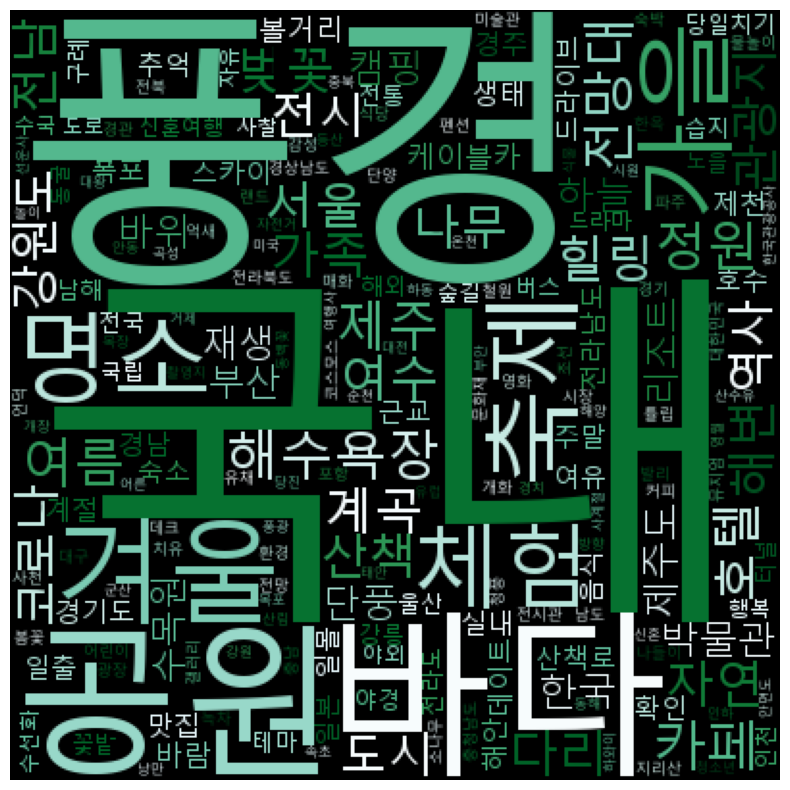

In [35]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBu': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [37]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'국내': 287,
 '겨울': 138,
 '축제': 101,
 '가을': 90,
 '명소': 82,
 '바다': 77,
 '여름': 73,
 '전남': 70,
 '코로나': 70,
 '강원도': 68,
 '신혼': 57,
 '제주도': 56,
 '가족': 56,
 '힐링': 55,
 '공원': 55,
 '단풍': 50,
 '여행사': 50,
 '삼성': 49,
 '서울': 47,
 '관광지': 45,
 '호텔': 43,
 '제주': 42,
 '부산': 41,
 '전라도': 40,
 '개장': 38,
 '해수욕장': 38,
 '정원': 38,
 '벚꽃': 37,
 '경남': 37,
 '한국': 37,
 '여수': 36,
 '순수': 36,
 '경주': 33,
 '체험': 33,
 '강릉': 29,
 '구례': 28,
 '해외': 28,
 '당일치기': 28,
 '다리': 28,
 '전국': 27,
 '캠핑': 26,
 '풍경': 26,
 '리조트': 26,
 '한국관광공사': 25,
 '남해': 25,
 '드라이브': 24,
 '역사': 24,
 '날짜': 24,
 '초록': 24,
 '해변': 24,
 '충북': 23,
 '뮤지엄': 23,
 '주세': 23,
 '충남': 22,
 '곡성': 22,
 '울산': 21,
 '카페': 21,
 '스카이': 21,
 '주말': 20,
 '근교': 20,
 '케이블카': 20,
 '거제': 20,
 '몰디브': 20,
 '도시': 20,
 '제천': 20,
 '박물관': 19,
 '대구': 19,
 '문화재': 19,
 '전망대': 19,
 '속초': 19,
 '일출': 19,
 '일자': 19,
 '계절': 18,
 '경기도': 18,
 '봄꽃': 18,
 '전북': 18,
 '보령': 18,
 '광주': 18,
 '전시': 18,
 '사천': 18,
 '개화': 18,
 '하와이': 17,
 '데이트': 17,
 '인하': 17,
 '포항': 17,
 '맞이': 17,
 '자연': 17,
 '발리': 17,
 

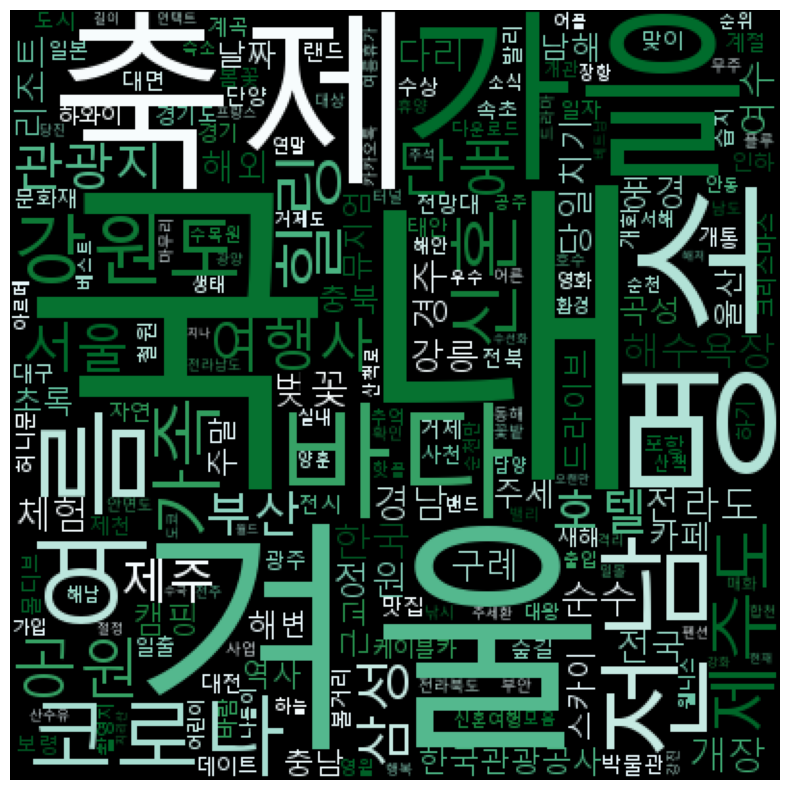

In [38]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [39]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'국내': 261,
 '겨울': 101,
 '가을': 83,
 '명소': 58,
 '전남': 55,
 '제주': 49,
 '축제': 48,
 '강원도': 39,
 '공원': 38,
 '여름': 37,
 '가족': 37,
 '서울': 35,
 '신혼여행': 34,
 '전라도': 34,
 '당일치기': 32,
 '부산': 31,
 '대구': 31,
 '경남': 30,
 '근교': 28,
 '데이트': 28,
 '여수': 27,
 '힐링': 26,
 '바다': 26,
 '제주도': 25,
 '드라이브': 25,
 '단풍': 24,
 '경주': 23,
 '해외': 23,
 '봄꽃': 23,
 '벚꽃': 22,
 '해수욕장': 22,
 '베스트': 21,
 '호텔': 21,
 '경기도': 20,
 '구례': 20,
 '실내': 20,
 '남해': 18,
 '여행사': 18,
 '볼거리': 17,
 '계곡': 17,
 '몽골': 17,
 '전망대': 17,
 '코로나': 17,
 '강릉': 16,
 '삼성': 16,
 '관광지': 16,
 '캠핑': 16,
 '한국': 16,
 '충북': 16,
 '전북': 16,
 '포항': 15,
 '제천': 15,
 '수목원': 15,
 '촬영지': 14,
 '태안': 14,
 '박물관': 14,
 '인천': 13,
 '케이블카': 13,
 '다리': 13,
 '정원': 13,
 '울산': 13,
 '체험': 13,
 '거제': 13,
 '장항': 12,
 '일본': 12,
 '강화': 12,
 '나들이': 12,
 '파주': 12,
 '곡성': 11,
 '순천': 11,
 '리조트': 11,
 '경북': 11,
 '공주': 11,
 '광주': 11,
 '랜드': 11,
 '영월': 11,
 '춘천': 11,
 '스카이': 11,
 '베트남': 10,
 '서산': 10,
 '대전': 10,
 '주말': 10,
 '속초': 10,
 '신안': 10,
 '순위': 10,
 '카페': 10,
 '언택트': 9,
 '억새': 9,
 '허

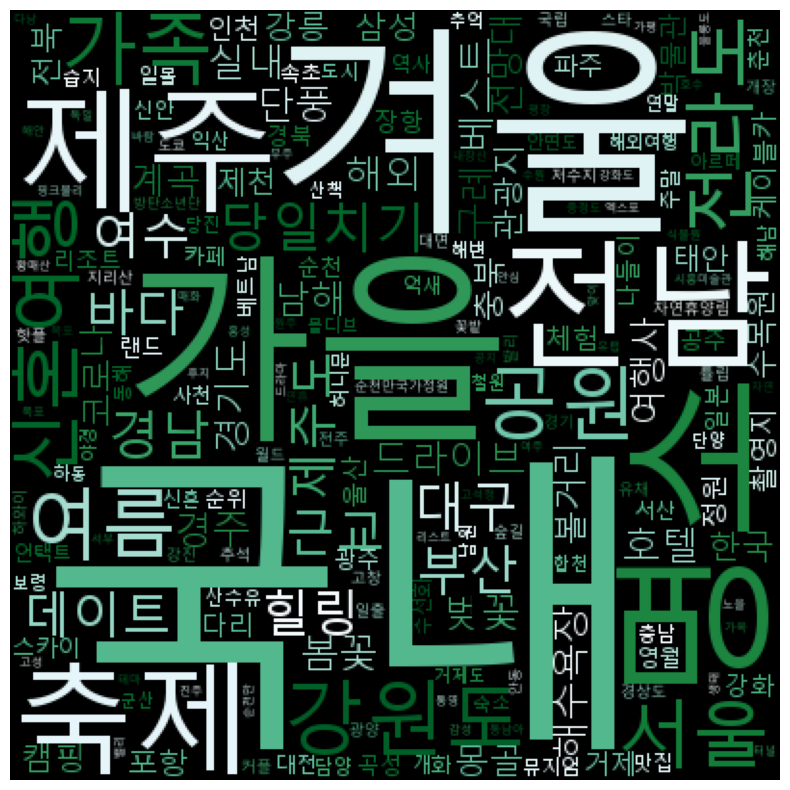

In [40]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Spring WordCloud]

In [41]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = spring_word_counts.set_index('word').to_dict()['count']
dic_word

{'벚꽃': 355,
 '축제': 333,
 '국내': 189,
 '풍경': 153,
 '공원': 151,
 '봄꽃': 151,
 '구례': 144,
 '매화': 143,
 '명소': 135,
 '철쭉': 128,
 '튤립': 118,
 '전남': 116,
 '개화': 105,
 '정원': 101,
 '수선화': 101,
 '바다': 99,
 '카페': 98,
 '녹차': 95,
 '나무': 92,
 '강진': 89,
 '산수유': 88,
 '경주': 85,
 '미륵사': 84,
 '랜드': 83,
 '서부': 82,
 '체험': 81,
 '박물관': 80,
 '해당화': 77,
 '힐링': 76,
 '전라남도': 76,
 '가족': 74,
 '추억': 73,
 '신혼여행': 73,
 '황매산': 72,
 '코로나': 70,
 '홍매': 69,
 '자연': 68,
 '한국': 67,
 '유채': 63,
 '안동': 63,
 '호텔': 62,
 '남도': 61,
 '순천': 61,
 '산책': 60,
 '석굴암': 58,
 '선암사': 56,
 '광양': 56,
 '대구': 55,
 '부안': 55,
 '캠핑': 55,
 '전시': 54,
 '사찰': 54,
 '선비': 53,
 '가옥': 53,
 '여수': 52,
 '지리산': 51,
 '볼거리': 51,
 '서산': 51,
 '하동': 51,
 '전라': 51,
 '만개': 50,
 '하와이': 50,
 '태안': 49,
 '전망대': 48,
 '군락지': 48,
 '서울': 48,
 '하늘': 47,
 '무주': 47,
 '역사': 47,
 '치즈': 46,
 '한복': 45,
 '재생': 44,
 '주말': 44,
 '경기': 44,
 '전통': 42,
 '도시': 42,
 '경남': 41,
 '여유': 41,
 '벽화': 41,
 '원주': 40,
 '리조트': 40,
 '신혼': 40,
 '관광지': 40,
 '다원': 40,
 '칸쿤': 39,
 '안면도': 39,
 '발리': 38,
 '놀이': 

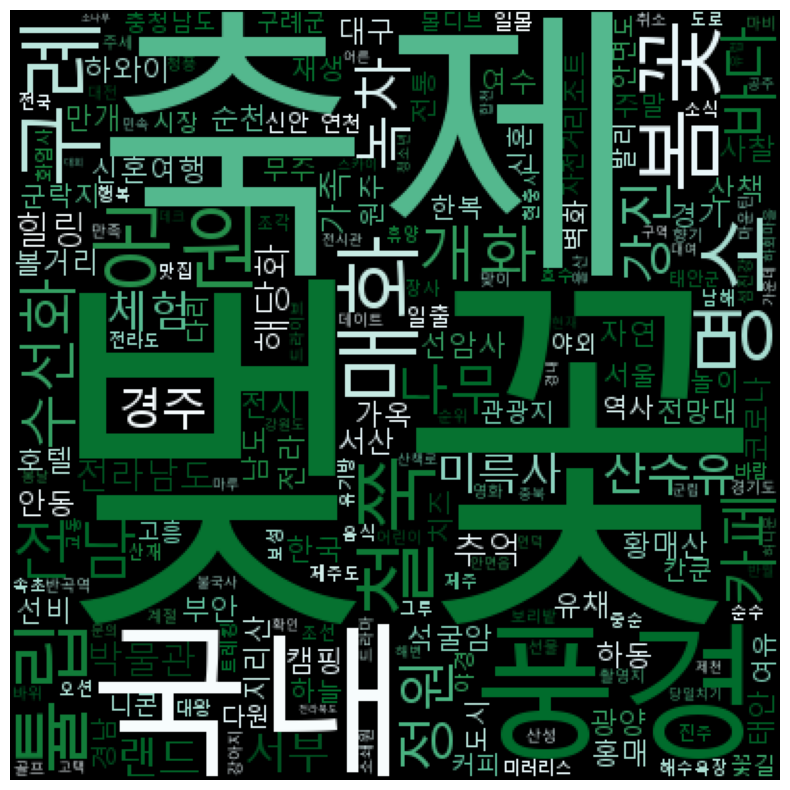

In [42]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Summer WordCloud]

In [43]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = summer_word_counts.set_index('word').to_dict()['count']
dic_word

{'해수욕장': 441,
 '여름': 392,
 '계곡': 294,
 '바다': 285,
 '해변': 218,
 '국내': 213,
 '여수': 180,
 '풍경': 172,
 '체험': 155,
 '강원도': 144,
 '제주': 125,
 '가족': 122,
 '자연': 113,
 '스카이': 112,
 '명소': 104,
 '호텔': 104,
 '물놀이': 101,
 '전망대': 93,
 '폭포': 92,
 '부산': 86,
 '카페': 86,
 '캠핑': 82,
 '공원': 81,
 '산림': 80,
 '다리': 79,
 '전시': 78,
 '바람': 77,
 '구만': 73,
 '케이블카': 73,
 '전남': 73,
 '한국': 72,
 '단양': 72,
 '나무': 72,
 '관광지': 72,
 '해남': 71,
 '하늘': 70,
 '바위': 67,
 '밀양': 67,
 '힐링': 67,
 '다낭': 65,
 '역사': 64,
 '국립': 59,
 '축제': 59,
 '산책로': 57,
 '모래': 56,
 '라인': 56,
 '치유': 56,
 '개장': 55,
 '놀이터': 54,
 '사천': 53,
 '격포': 53,
 '제주도': 53,
 '수국': 51,
 '해외': 51,
 '시원': 48,
 '부안': 48,
 '볼거리': 48,
 '숙소': 47,
 '도시': 47,
 '숲길': 47,
 '해안': 47,
 '문화재': 47,
 '강릉': 47,
 '리조트': 46,
 '코로나': 46,
 '휴가': 46,
 '전국': 46,
 '호수': 46,
 '경상남도': 45,
 '태교': 44,
 '상상': 44,
 '언덕': 44,
 '몽골': 44,
 '노을': 43,
 '대구': 43,
 '주말': 43,
 '거제': 43,
 '골프': 43,
 '암반': 43,
 '경남': 42,
 '자유': 41,
 '평창': 41,
 '산책': 41,
 '맛집': 40,
 '신덕': 40,
 '전라남도': 40,
 '생태': 40,
 '펜션':

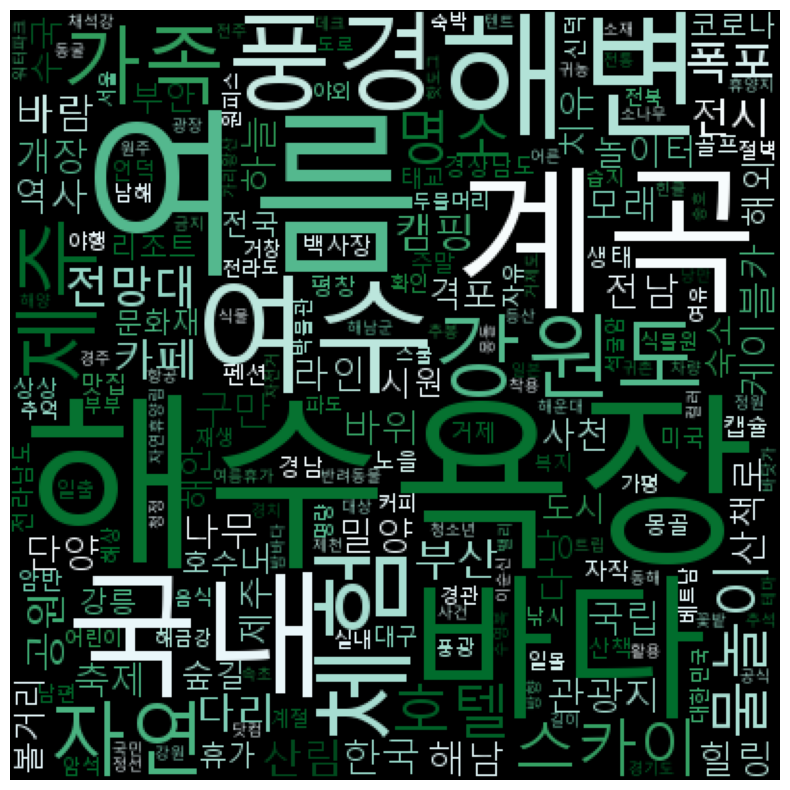

In [44]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Autumn WordCloud]

In [45]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = autumn_word_counts.set_index('word').to_dict()['count']
dic_word

{'가을': 388,
 '공원': 243,
 '풍경': 155,
 '철원': 144,
 '꽃밭': 142,
 '단풍': 139,
 '다리': 135,
 '국내': 134,
 '억새': 128,
 '정원': 124,
 '축제': 121,
 '구절초': 110,
 '제천': 97,
 '하늘': 94,
 '전망대': 91,
 '체험': 90,
 '명소': 89,
 '고석정': 88,
 '서울': 85,
 '가족': 85,
 '생태': 80,
 '나무': 73,
 '용눈이오름': 72,
 '코스모스': 71,
 '재생': 65,
 '카페': 64,
 '정읍': 59,
 '아가페': 54,
 '힐링': 54,
 '자연': 53,
 '산책': 53,
 '대둔산': 52,
 '익산': 51,
 '제주': 51,
 '케이블카': 50,
 '상사화': 50,
 '코로나': 49,
 '내장산': 49,
 '오름': 48,
 '강원도': 48,
 '근교': 48,
 '경기도': 47,
 '청풍': 46,
 '캠핑': 45,
 '주말': 45,
 '경남': 44,
 '핑크뮬리': 44,
 '선운사': 43,
 '건봉사': 43,
 '테마': 42,
 '전라도': 40,
 '경주': 40,
 '불갑사': 39,
 '충북': 39,
 '역사': 39,
 '바다': 39,
 '옥수': 39,
 '갯골': 38,
 '당일치기': 37,
 '남해': 36,
 '전시': 36,
 '남당항': 36,
 '전남': 36,
 '시흥': 35,
 '화담': 35,
 '관광지': 34,
 '전북': 34,
 '파주': 34,
 '감성': 34,
 '함양': 33,
 '데이트': 33,
 '드라이브': 33,
 '고창': 33,
 '전라북도': 33,
 '낭만': 33,
 '남원': 32,
 '나들이': 32,
 '버스': 32,
 '안개': 32,
 '저수지': 31,
 '박물관': 31,
 '고인돌': 31,
 '은행나무': 30,
 '추억': 29,
 '불국사': 29,
 '곡성': 29,
 '바

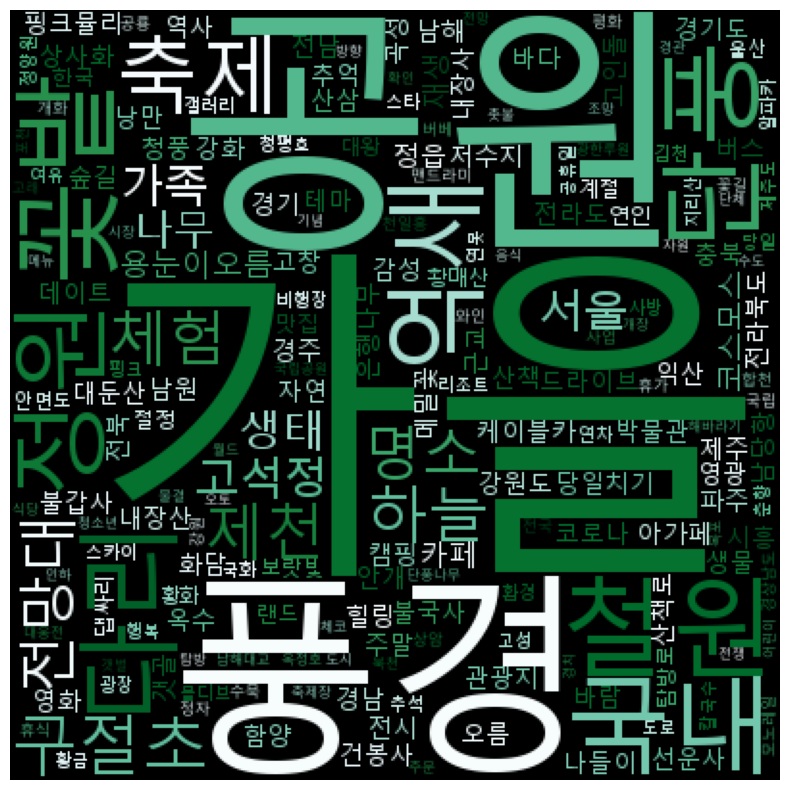

In [46]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Winter WordCloud]

In [47]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = winter_word_counts.set_index('word').to_dict()['count']
dic_word

{'겨울': 549,
 '국내': 241,
 '바다': 227,
 '풍경': 196,
 '축제': 164,
 '케이블카': 122,
 '명소': 104,
 '제주도': 103,
 '도시': 97,
 '강릉': 97,
 '제주': 96,
 '포항': 92,
 '체험': 92,
 '공원': 88,
 '전망대': 87,
 '전시': 85,
 '해변': 82,
 '카페': 82,
 '온천': 81,
 '힐링': 80,
 '정원': 71,
 '크리스마스': 70,
 '박물관': 68,
 '뮤지엄': 68,
 '코로나': 67,
 '대만': 67,
 '사천': 67,
 '자연': 64,
 '경기도': 64,
 '동굴': 63,
 '정류장': 63,
 '거제': 63,
 '여수': 63,
 '강원도': 62,
 '가족': 62,
 '지심': 60,
 '갤러리': 60,
 '브루나이': 60,
 '산책로': 59,
 '단양': 59,
 '하늘': 58,
 '실내': 57,
 '해수욕장': 57,
 '담양': 56,
 '볼거리': 55,
 '관광지': 55,
 '전남': 55,
 '재생': 54,
 '미술관': 54,
 '맛집': 53,
 '서울': 53,
 '우도': 53,
 '한국': 52,
 '식물원': 50,
 '산책': 50,
 '일몰': 50,
 '해안': 49,
 '리조트': 49,
 '캠핑': 49,
 '경남': 47,
 '프랑스': 47,
 '터널': 46,
 '광장': 46,
 '국립': 46,
 '수목원': 46,
 '동백꽃': 45,
 '나무': 44,
 '발리': 44,
 '다리': 43,
 '목포': 43,
 '역사': 43,
 '일출': 41,
 '세종': 41,
 '통영': 41,
 '데이트': 41,
 '니스': 40,
 '해외': 40,
 '신륵사': 39,
 '칼국수': 39,
 '확인': 38,
 '숙소': 37,
 '경기': 37,
 '강원': 37,
 '연말': 36,
 '호텔': 36,
 '당일치기': 36,
 '근교': 36,
 '충

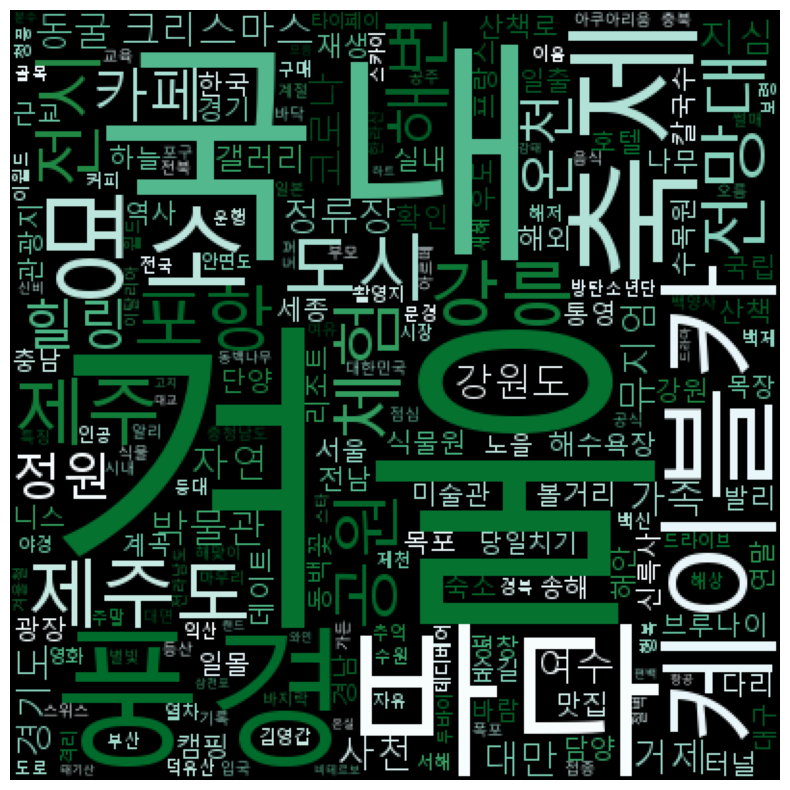

In [48]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기